# Parameter estimation for GW250114

1. Load 20 s of strain data around GW250114 from `gw250114_20s.txt`.
    - Assumption: data is of the format |time, strain| 
    - Data for the off-source noise is also loaded.
    
2. Implement a matched-filter pipeline to estimate:
   - source & detector-frame chirp mass M
   - mass ratio q = m2 / m1 (q < 1)
   - coalescence time $t_{coa}$
   - coalescence phase $\psi_{coa}$
   
3. Re-do the estimation with **Bayesian inference** using bilby.
   
The found values are compared to those from the original paper reporting this signal, A. G. Abac et al. (LIGO Scientific, Virgo, and KAGRA Collaborations), GW250114: Testing Hawking’s Area Law and the Kerr Nature of Black Holes, Physical Review Letters, published 10 September 2025., DOI: 10.1103/kw5g-d732.

# Project goal description
The waveform of a binary black hole inspiral is primarily characterized by four parameters. The chirp mass
$\mathcal{M}$ is the best-measured quantity and determines the rate at which the binary inspiral accelerates (the ''chirp''). The mass ratio $q = m_2/m_1$ enters through higher-order post-Newtonian corrections and controls subtler modifications to the phase and amplitude beyond the chirp-dominated regime. The coalescence time $t_c$ sets the moment when the merger occurs and corresponds to a linear phase shift in the frequency domain. Finally, the coalescence phase $\phi_c$ specifies the orbital phase of the binary at merger and
introduces an overall constant phase rotation of the waveform.

In [1]:
# all packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from scipy.fft import rfft, rfftfreq, irfft
from pycbc.waveform import get_fd_waveform
from gwpy.timeseries import TimeSeries
from scipy import signal
from tqdm.notebook import tqdm

/home/liskably/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/liskably/.local/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-

# 1. Data Loading

In [2]:
# Physical constants
G = 6.6743e-11
c = 2.99792458e8
MSUN_SI = 1.98847e30

# Analysis settings
event_name = "GW250114"
data_filename = "gw250114_20s.txt"
noise_filename = "gw250114_50s_offsource.txt"

# Load data and reframe time axis
data = np.loadtxt(data_filename)

t_abs = data[:, 0]        # absolute timestamps (~1.42e9 s, unix time?)
h = data[:, 1]            # strain

# Reframe time so it starts at 0
t = t_abs - t_abs[0]

# Compute sampling interval and sampling frequency
dt = t[1] - t[0]
fs = 1.0 / dt
print("============= Signal Data")
print(f"Sampling interval dt = {dt:.9f} s")
print(f"Sampling frequency fs = {fs:.3f} Hz")
print(f"Observation duration Tobs ≈ {t[-1]:.3f} s")

# Frequency band for analysis
flow = 20.0          # low-frequency cutoff for analysis
fhigh = 600      # high-frequency cutoff

# Load off source noise data
data_noise = np.loadtxt(noise_filename)

t_noise_abs = data_noise[:, 0]        # absolute timestamps (~1.42e9 s, unix time?)
h_noise = data_noise[:, 1]            # strain

# Reframe time so it starts at 0, convert to seconds
t_noise = t_noise_abs - t_noise_abs[0]

# Compute sampling interval and sampling frequency from the data
dt_noise = t_noise[1] - t_noise[0]
fs_noise = 1.0 / dt_noise
print("============= Off source data")
print(f"Sampling interval dt = {dt_noise:.9f} s")
print(f"Sampling frequency fs = {fs_noise:.3f} Hz")
print(f"Observation duration Tobs ≈ {t_noise[-1]:.3f} s")

============= Signal Data
Sampling interval dt = 0.000244141 s
Sampling frequency fs = 4096.000 Hz
Observation duration Tobs ≈ 20.000 s
============= Off source data
Sampling interval dt = 0.000244141 s
Sampling frequency fs = 4096.000 Hz
Observation duration Tobs ≈ 50.000 s


# Raw data visualisation

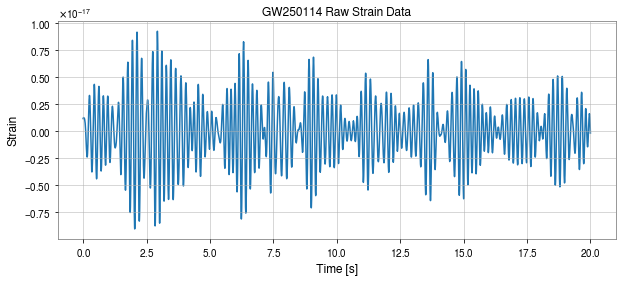

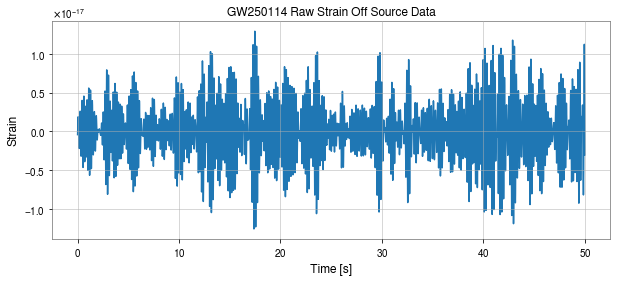

In [3]:
# Plotting the data just for visualisation purposes

# from above t is the time array, h is strain

# plot raw strain data
plt.figure(figsize=(10, 4))
plt.plot(t, h)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title(f"{event_name} Raw Strain Data")
plt.grid(True)
plt.show()

# plot raw off-source strain data
plt.figure(figsize=(10, 4))
plt.plot(t_noise, h_noise)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title(f"{event_name} Raw Strain Off Source Data")
plt.grid(True)
plt.show()

/home/liskably/.local/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


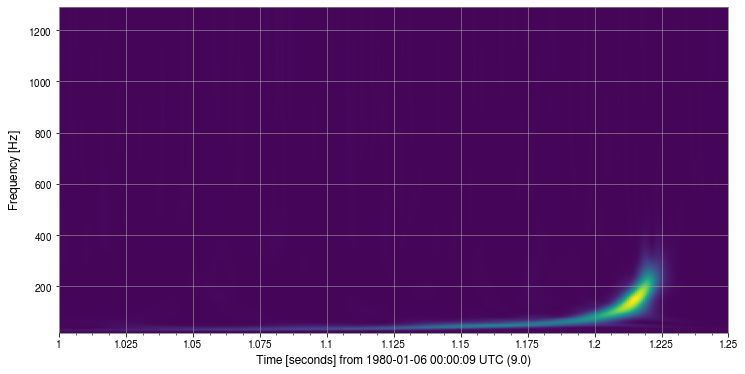

In [4]:
# Q-Transform plot to see the signal
ts = TimeSeries(h, dt=dt)
q = ts.q_transform(outseg=(10,10.25)) # selecting the time frame of the signal

plot = q.plot()
plot.show()

# PSD Calculation & ASD Visualisation
This cell below estimates the detector’s noise amplitude spectral density (ASD) and compares it to the measured strain spectrum of the data. The off-source noise time series $h_{\text{noise}}(t)$ is defined as a GWPy TimeSeries so that its power spectral density (PSD). The noise data are split into overlapping 4-second segments, each segment is Fourier-transformed, squared, and averaged in frequency, and the median across segments yields a robust estimate of the average noise power per unit frequency. Taking $\sqrt{S_n(f)}$ gives the noise ASD (but I just used the .asd method). The on-source strain $h(t)$ is then windowed with a Tukey taper to suppress spectral leakage and Fourier-transformed with the $dt$ normalization, producing $h(f)$. Because $|h(f)|$ carries units of strain·seconds, multiplying it by $\sqrt{T_{\text{obs}}}$ yields an ASD-like quantity that can be directly compared to $\sqrt{S_n(f)}$. Plotting both curves on a logarithmic frequency axis shows how the measured strain amplitude sits relative to the detector’s average noise spectrum, revealing where the gravitational-wave signal rises above the noise floor.

My goal for this section was visualisation - to understand the data a bit better and compare it to the ASD plots we have seen. Especially because plotting the raw data really does not show you (visually) where the signal may be. The Q-transform plot clearly shows a signal though. Still, I feel that the plots below show you the ASD for the noise and the signal quite close together. Maybe the plots would look better if I suppressed the noise from the signal. Therefore, I proceed to whiten and band pass the data.

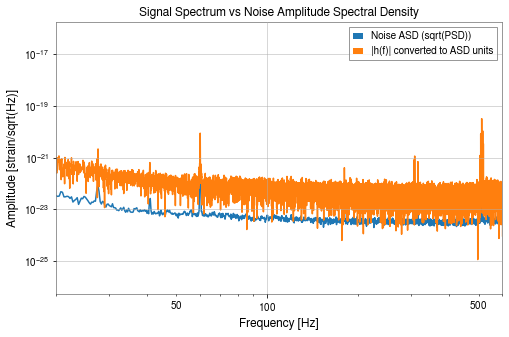

In [5]:
# GWPy Timeseries object containing the strain of the noise
ts_noise = TimeSeries(h_noise, dt=dt_noise)

# The PSD describes the average noise power per unit frequency
# property of the detector instrument, not the GW signal

psd_ts_noise = ts_noise.psd(fftlength=4.0)
f_psd_noise = np.array(psd_ts_noise.frequencies.value)    # Hz
psd_noise = np.array(psd_ts_noise.value)                  # power spectral density

asd_noise = ts_noise.asd(fftlength=4.0)                   # amplitude spectral density

# FFT of the actual data (signal + noise)
window = signal.windows.tukey(len(h), alpha=0.1)
h_win = h * window

hf = np.fft.rfft(h_win) * dt # normalised with dt 
freqs = np.fft.rfftfreq(len(h), d=dt)

# Convert |h(f)| into ASD-like units:
Tobs = len(h) * dt                # total observation time
asd_signal = np.abs(hf) * np.sqrt(Tobs)  # ASD-equivalent amplitude

# Plot
plt.figure(figsize=(8, 5))

plt.loglog(f_psd_noise, asd_noise, label='Noise ASD (sqrt(PSD))')
plt.loglog(freqs, asd_signal, label='|h(f)| converted to ASD units')

plt.xlim(flow, fhigh)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [strain/sqrt(Hz)]')
plt.title('Signal Spectrum vs Noise Amplitude Spectral Density')
plt.grid(True)
plt.legend()
plt.show()


# plot this band-passed to get a nicer ASD

# Whitened + band-passed time series

When you whiten the data and then band-pass it, you (1) flatten the noise across all frequencies, and (2) throw away the parts of the spectrum where there is no useful signal. The result is that the gravitational-wave chirp, which was almost invisible in the raw data, now appears clearly in the time-domain plot. I am finally happy with a visualisation of the signal.

Whitening takes the data and divides each frequency component by the detector’s noise level at that frequency. If the detector is very noisy at low frequencies, whitening shrinks those parts of the signal and if it is quiet at some frequencies, whitening boosts them. After whitening, the noise has roughly the same strength at all frequencies so the gravitational-wave signal stands out more clearly. Mathematically, whitening replaces $h(f)$ with $h(f)/\sqrt{S_n(f)}$, where $S_n(f)$ is the noise power spectral density.

Band-passing keeps only the frequency range where the signal is strongest. For binary black hole mergers like this one, almost all of the detectable signal lives between about 20 and 600 Hz. Frequencies outside this band contain mostly noise, so removing them makes the signal much easier to see.

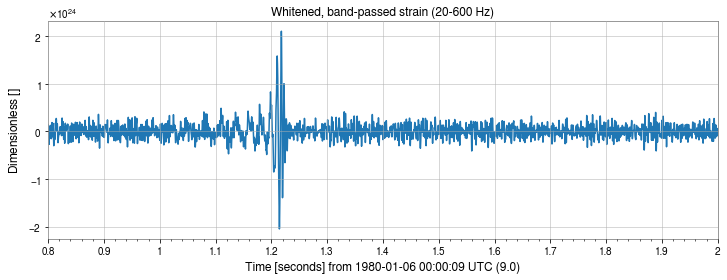

In [6]:
# Whitened + band-passed time series with gwpy

# Build a TimeSeries for the on-source data
ts = TimeSeries(h, dt=dt)

# Whiten using the off-source PSD
white_ts = ts.whiten(asd=psd_ts_noise)

# Band-pass in 40-400 Hz
bp_white_ts = white_ts.bandpass(20, 600)

# center time near the event
t0 = t[0] + 10.0

# Time-domain view: whitened, band-passed data
bp_white_ts.plot(
    xlim=(t0 - 0.2, t0 + 1),
    title='Whitened, band-passed strain (20-600 Hz)'
)

plt.show()

# 2. Matched-filter parameter estimation (data preparation)
This block constructs the frequency grid, selects the analysis band, aligns the PSD onto that grid, and prepares the Fourier-domain data and noise level so that the matched-filter inner product can be computed.

In [7]:
def make_frequency_grid(N, dt, flow, fhigh):
    '''Return one-sided positive frequency grid for rfft'''
    freqs = rfftfreq(N, dt)
    mask = (freqs >= flow) & (freqs <= fhigh)
    return freqs, mask

def interpolate_psd(freqs_target, f_psd, psd):
    '''Interpolate PSD onto target frequency grid'''
    psd_interp = np.interp(freqs_target, f_psd, psd)
    return psd_interp

def noise_weighted_inner_product(hf1, hf2, freqs, psd):
    '''
    (a|b) = 4 Re \int df a*(f) b(f) / S_n(f)
    Approximate with sum over discrete frequencies.
    '''
    df = freqs[1] - freqs[0]
    integrand = np.conj(hf1) * hf2 / psd
    return 4.0 * np.real(np.sum(integrand) * df)


In [8]:
N = len(h)
freqs, fmask = make_frequency_grid(N, dt, flow, fhigh)

# FFT of the full data normalised with dt
hf = rfft(h) * dt

# Restrict to analysis band
freqs_an = freqs[fmask]
hf_an = hf[fmask]

psd_an = interpolate_psd(freqs_an, f_psd_noise, psd_noise)

# matched-filter evaluation (vectorized)
In the original implementation, waveform generation and matched-filter SNR calculation were performed inside four nested Python loops, which caused millions of repeated calls to the waveform generator and made the code extremely slow. The performance was improved by restructuring the computation so that the expensive operation (the PyCBC waveform generation) is executed only once per mass pair. The resulting frequency-domain template is then reused for all time and phase shifts using simple complex exponentials, which are cheap to compute. Next, the evaluation over all candidate coalescence times and phases was vectorized, allowing thousands of SNR values to be computed in a single set of array operations instead of Python loops. This reduces Python overhead.

The code below does matched filtering by scanning over a grid of binary black hole masses and coalescence times/phases to find which template best matches the data. For each pair of masses $(m_1, m_2)$, fd_inspiral_template_base uses get_fd_waveform to generate a model waveform in the frequency domain on the same frequency grid as the data, then interpolates it and zeros it outside the analysis band. Inside the loop, this template $h_0(f)$ is first normalized using the noise PSD so that its self–inner product $(h_0|h_0)$ is 1 after dividing by norm. The code then precomputes the noise-weighted product $\overline{h_0(f)},h_{\rm data}(f)/S_n(f)$, and for each trial coalescence time $t_c$ it multiplies by a complex phase factor $e^{2\pi i f t_c}$ and sums over frequency to get a matched-filter output (an inner product between template and data). A second phase factor $e^{-i\phi_c}$ is applied to scan over coalescence phases $\phi_c$, giving a grid of complex SNR values; their magnitudes divided by norm give the matched-filter SNR for each $(m_1, m_2, t_c, \phi_c)$ point. $\tfrac{1}{2},\text{SNR}^2$ is taken as the log-likelihood, and the maximum is found over the whole grid, and the corresponding best-fit masses, coalescence time, phase, and SNR are recorded. These final values are reported, and the chirp mass $\mathcal{M} = (m_1 + m_2),\eta^{3/5}$ with $\eta = m_1 m_2 / (m_1 + m_2)^2$ is calculated. The output is compared to the results reported in the original paper.

In [15]:
def fd_inspiral_template_base(freqs, m1, m2, dist_Mpc):
    '''Base frequency-domain waveform at tc=0, phic=0 on freq grid.'''
    delta_f = freqs[1] - freqs[0]

    hp, hc = get_fd_waveform(
        approximant='IMRPhenomD',
        mass1=m1,
        mass2=m2,
        delta_f=delta_f,
        f_lower=flow,
        f_final=fhigh,
        distance=dist_Mpc
    )
    
    f_temp = np.array(hp.sample_frequencies)
    hp_arr = np.array(hp)

    # interpolate onto grid
    hp_re = np.interp(freqs, f_temp, hp_arr.real, left=0.0, right=0.0)
    hp_im = np.interp(freqs, f_temp, hp_arr.imag, left=0.0, right=0.0)
    h0 = hp_re + 1j * hp_im

    # nullify values outside of range
    h0[(freqs < flow) | (freqs > fhigh)] = 0.0 
    return h0

def chirp_mass(m1, m2):
    M = m1 + m2
    eta = (m1 * m2) / M**2
    return M * eta**(3.0/5.0)

# will be set inside the loop
best_loglik = -np.inf
best_params = None

df = freqs_an[1] - freqs_an[0]

m1_grid = np.linspace(30.0, 50.0, 11)   # solar masses
m2_grid = np.linspace(30.0, 40.0, 11)

# 0.5s ~  
tc_guess = t[0] + 10.0   # somewhere in the middle; refine
tc_grid = tc_guess + np.linspace(-0.5, 0.5, 101)  # ±500 ms
phic_grid = np.linspace(0, 2*np.pi, 8)

# total number of (m1,m2) pairs
# removing any case where m2 > m1
mass_pairs = [(m1, m2) for m1 in m1_grid for m2 in m2_grid if m2 <= m1]

# Mass grid search
for m1, m2 in tqdm(mass_pairs, desc="Mass grid search", unit="pair"):
    
    h0 = fd_inspiral_template_base(freqs_an, m1, m2, dist_Mpc=400.0) * dt

    # precompute norm
    denom = 4.0 * np.real(np.sum(np.conj(h0) * h0 / psd_an) * df)
    norm = np.sqrt(denom)

    # precompute piece that doesn’t depend on tc, \phi_c
    base_integrand = np.conj(h0) * hf_an / psd_an
    
    # Can basically replace this section with an ifft to improve performance
    
    # ---- vectorize over tc and \phi_c ----
    phase_tc = np.exp(1j * 2.0 * np.pi * freqs_an[None, :] * tc_grid[:, None])  # (N_tc, N_f)

    inner_tc = 4.0 * np.real(
        np.sum(base_integrand[None, :] * phase_tc, axis=-1) * df
    )  # (N_tc,)

    inner_all = inner_tc[:, None] * np.exp(-1j * phic_grid[None, :])  # (N_tc, N_phi)

    snr = inner_all / norm
    snr_abs = np.abs(snr)
    loglik = 0.5 * snr_abs**2

    idx_flat = np.argmax(loglik)
    best_loglik_m = loglik.flat[idx_flat]

    if best_loglik_m > best_loglik:
        best_loglik = best_loglik_m
        i_tc, i_phi = np.unravel_index(idx_flat, loglik.shape)
        tc_best = tc_grid[i_tc]
        phic_best = phic_grid[i_phi]
        snr_best = snr_abs[i_tc, i_phi]
        best_params = (m1, m2, tc_best, phic_best, snr_best)

# printing best fit values
print("Best-fit parameters (detector frame):")
print(f"m1 = {best_params[0]:.2f} Msun, m2 = {best_params[1]:.2f} Msun")
print(f"q = {best_params[1]/best_params[0]:.3f}")
# t_coa and phi_coa are reported just to check that we're looking at the correct
# part of the data, expecting signal around 10.25s
print(f"t_coa ~ {best_params[2]:.6f} s, phi_coa ~ {best_params[3]:.2f} rad")
print(f"Matched-filter SNR ≈ {best_params[4]:.1f}")

M_chirp_best = chirp_mass(best_params[0], best_params[1])
print(f"Best-fit chirp mass = {M_chirp_best:.2f} Msun")

Mass grid search:   0%|          | 0/91 [00:00<?, ?pair/s]

Best-fit parameters (detector frame):
m1 = 42.00 Msun, m2 = 33.00 Msun
q = 0.786
t_coa ~ 10.220000 s, phi_coa ~ 0.90 rad
Matched-filter SNR ≈ 59.7
Best-fit chirp mass = 32.36 Msun


The detector-frame parameters reported by the LIGO Virgo KAGRA Collaboration for the GW250114 event indicate that the system was an almost equal-mass binary black hole merger. The collaboration finds detector-frame component masses of approximately 

$$m_1 \simeq 32.6 \text{--} 34.9 \,M_\odot, \qquad m_2 \simeq 30.6 \text{--} 33.2 \,M_\odot,$$

corresponding to a detector-frame chirp mass of 
$$\mathcal{M}_{\mathrm{det}} \simeq 30.3\text{--}31.6\,M_\odot.$$
The mass ratio is tightly constrained and satisfies 
$$q = \frac{m_2}{m_1} \gtrsim 0.91,$$
strongly favoring a nearly symmetric system. These measurements imply a total detector-frame mass of 
$$M_{\mathrm{tot}} = m_1 + m_2 \simeq 71\,M_\odot.$$

# Discussion : 
I initially had an SNR order of magnitude ~100,000, speaking with Pat and normalising the strain h with dt brought this down. I then increased the range of masses that I was iterating through because m1 was hitting the top value (35 at the time). I found out that my code actually has best fit parameters m1 = 42, m2 = 33, with detector frame chirp mass still reasonably close. However, I was not too satisfied and hoping that I could still get the values closer I tried switching around the grid search to go through (Mc, q) instead of (m1, m2) so that the sampling is done better in the more important regions in phase space rather than linearly over mass combinations. This is shown below, but gives practically the same results. Therefore, my conclusion for the moment is that I have hit the accuracy threshold for this method of using a single detectors data and this method. I'll try bayesian inference to see if I get closer to the reported values below.

In [10]:
def fd_inspiral_template_base(freqs, m1, m2, dist_Mpc):
    """Base frequency-domain waveform at tc=0, phic=0 on freq grid."""
    delta_f = freqs[1] - freqs[0]

    hp, hc = get_fd_waveform(
        approximant='IMRPhenomD',
        mass1=m1,
        mass2=m2,
        delta_f=delta_f,
        f_lower=flow,
        f_final=fhigh,
        distance=dist_Mpc,
    )
    f_temp = np.array(hp.sample_frequencies)
    hp_arr = np.array(hp)

    # interpolate onto your grid
    hp_re = np.interp(freqs, f_temp, hp_arr.real, left=0.0, right=0.0)
    hp_im = np.interp(freqs, f_temp, hp_arr.imag, left=0.0, right=0.0)
    h0 = hp_re + 1j * hp_im

    h0[(freqs < flow) | (freqs > fhigh)] = 0.0
    return h0


def chirp_mass(m1, m2):
    M = m1 + m2
    eta = (m1 * m2) / M**2
    return M * eta ** (3.0 / 5.0)


def mc_q_to_masses(Mc, q):
    """
    Convert chirp mass Mc and mass ratio q = m2/m1 (<=1)
    to component masses m1 >= m2.
    """
    # symmetric mass ratio
    eta = q / (1.0 + q) ** 2
    # total mass
    Mtot = Mc * eta ** (-3.0 / 5.0)
    m1 = Mtot / (1.0 + q)
    m2 = q * m1
    return m1, m2


best_loglik = -np.inf
best_params = None

df = freqs_an[1] - freqs_an[0]

# ---- Mc–q grid instead of m1–m2 ----
# You can tune these ranges/resolution
Mc_grid = np.linspace(28.0, 34.0, 13)   # detector-frame chirp mass [Msun]
q_grid  = np.linspace(0.8, 1.0, 11)     # mass ratio m2/m1 (<=1)

# coalescence time grid (same as before)
tc_guess = t[0] + 10.0
tc_grid = tc_guess + np.linspace(-0.5, 0.5, 101)  # ±0.5 s

# we will no longer grid over phi_c; we get it from the complex SNR
mass_pairs = []
for Mc in Mc_grid:
    for q in q_grid:
        m1, m2 = mc_q_to_masses(Mc, q)
        # Optional sanity cuts: physical masses, ordering, etc.
        if m2 > m1:  # shouldn't happen for q<=1, but just in case
            m1, m2 = m2, m1
        if m1 <= 0 or m2 <= 0:
            continue
        mass_pairs.append((Mc, q, m1, m2))

print(f"Total Mc–q grid points: {len(mass_pairs)}")

for Mc, q, m1, m2 in tqdm(mass_pairs, desc="Mc–q grid search", unit="point"):

    # template on analysis band
    h0 = fd_inspiral_template_base(freqs_an, m1, m2, dist_Mpc=400.0) * dt

    # template norm (h|h)
    denom = 4.0 * np.real(np.sum(np.conj(h0) * h0 / psd_an) * df)
    if denom <= 0:
        continue
    norm = np.sqrt(denom)

    # precompute piece that doesn’t depend on tc
    base_integrand = np.conj(h0) * hf_an / psd_an  # (N_f,)

    # ---- vectorize over tc, keep complex z(tc) ----
    phase_tc = np.exp(1j * 2.0 * np.pi * freqs_an[None, :] * tc_grid[:, None])  # (N_tc, N_f)

    # complex matched-filter time series z(tc)
    z_tc = 4.0 * np.sum(base_integrand[None, :] * phase_tc, axis=-1) * df  # (N_tc,), complex

    snr_tc = np.abs(z_tc) / norm
    loglik = 0.5 * snr_tc**2

    i_tc = np.argmax(loglik)
    best_loglik_m = loglik[i_tc]

    if best_loglik_m > best_loglik:
        best_loglik = best_loglik_m
        tc_best = tc_grid[i_tc]
        snr_best = snr_tc[i_tc]
        z_best = z_tc[i_tc]
        phic_best = np.angle(z_best)  # coalescence phase in [-pi, pi]

        best_params = (Mc, q, m1, m2, tc_best, phic_best, snr_best)

# best fit values
Mc_best, q_best, m1_best, m2_best, tc_best, phic_best, snr_best = best_params

print("Best-fit parameters (detector frame):")
print(f"Mc = {Mc_best:.2f} Msun")
print(f"q  = {q_best:.3f}")
print(f"m1 = {m1_best:.2f} Msun, m2 = {m2_best:.2f} Msun")
# t_coa and phi_coa are reported just to check that we're looking at the correct
# part of the data, expecting signal around 10.25s
print(f"t_coa  ~ {tc_best:.6f} s")
print(f"phi_coa ~ {phic_best:.3f} rad")
print(f"Matched-filter SNR ≈ {snr_best:.1f}")
M_chirp_best_check = chirp_mass(m1_best, m2_best)
print(f"Chirp mass from (m1,m2) = {M_chirp_best_check:.2f} Msun")


Total Mc–q grid points: 143


Mc–q grid search:   0%|          | 0/143 [00:00<?, ?point/s]

Best-fit parameters (detector frame):
Mc = 32.50 Msun
q  = 0.800
m1 = 41.79 Msun, m2 = 33.43 Msun
t_coa  ~ 10.220000 s
phi_coa ~ 0.188 rad
Matched-filter SNR ≈ 59.6
Chirp mass from (m1,m2) = 32.50 Msun


# 3. Parameter Estimation using Bayesian Inference - Bilby

This code sets up a full (but simplified) Bayesian parameter estimation for the GW250114 signal using bilby. First, it builds a realistic single-detector model by creating an Interferometer with Hanford-like geometry, attaching the noise PSD estimated earlier, and loading a short 4-second stretch of strain data around the event time as the data to analyse. It then constructs a WaveformGenerator that produces frequency-domain binary black hole waveforms (lal_binary_black_hole with the IMRPhenomD approximant) on the same time and frequency grid as the data. On top of this, it defines priors for the unknown parameters: it samples uniformly over the component masses mass_1 and mass_2, fixing geocent_time and phase to the best-fit values found previously by matched filtering, and fixing all other parameters (distance, sky position, inclination, spins) to constant values.

The GravitationalWaveTransient likelihood then evaluates, for any proposed set of masses, how well the model waveform matches the data under the assumption of stationary Gaussian noise (using the standard noise-weighted inner product with the PSD). Finally, bilby.run_sampler calls the Dynesty nested sampler, which explores the mass parameter space according to Bayes’ theorem. It works by combining the priors with the likelihood—to generate a posterior distribution for mass_1 and mass_2.

ChatGPT was used to help with the bilby set up and dive through the documentation. The goal here was just to have a high level implementation to understand whether there is an improvement seen by using Bayesian inference. While (as discussed in the results below), the mass parameters m1 and m2 are significantly improved, the chirp mass is still off. I would have to dive deeper to figure out which part of the assumptions that I've made is responsible for this.

In [11]:
# ==========================
# Bilby parameter estimation
# ==========================
import bilby
from bilby.gw.detector.interferometer import Interferometer
from bilby.gw.detector.psd import PowerSpectralDensity

# Basic settings from the data
sampling_frequency = 1.0 / dt
duration = t[-1] - t[0]              # ~ 20 s
start_time = 0.0                     # your t is already shifted so t[0] = 0

print(f"Duration ~ {duration:.3f} s, fs = {sampling_frequency:.1f} Hz")

# PSD object for bilby (using GWpy PSD)

psd_bilby = PowerSpectralDensity(
    frequency_array=f_psd_noise,
    psd_array=psd_noise,
)

# Build a single interferometer explicitly

# Geometry parameters for a Hanford-like detector (approximate)
length = 4000.0          # m
latitude = 46.455        # degrees
longitude = -119.408     # degrees
elevation = 0.142        # km
xarm_azimuth = 125.9994  # degrees
yarm_azimuth = 215.9994  # degrees

ifo = Interferometer(
    name="H1",
    power_spectral_density=psd_bilby,
    minimum_frequency=flow,
    maximum_frequency=fhigh,
    length=length,
    latitude=latitude,
    longitude=longitude,
    elevation=elevation,
    xarm_azimuth=xarm_azimuth,
    yarm_azimuth=yarm_azimuth,
)

# strain data
# Choose a smaller window around the event, e.g. [9, 13] s in your current 0–20 s array
t_min = 9.0
t_max = 13.0

mask = (t >= t_min) & (t <= t_max)
t_short = t[mask]
h_short = h[mask]

# Update duration and start_time
duration = t_short[-1] - t_short[0]
start_time = t_short[0]  # often 9.0 now

print(duration, start_time)

# Use these in the interferometer setup:
sampling_frequency = 1.0 / dt

ifo.strain_data.set_from_time_domain_strain(
    h_short,
    sampling_frequency=sampling_frequency,
    time_array=t_short,
)

print("Interferometer and PSD set up.")

# Waveform generator (IMRPhenomD, frequency-domain BBH)

waveform_arguments = dict(
    waveform_approximant='IMRPhenomD',
    reference_frequency=50.0,
    minimum_frequency=flow,
)

waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=None,
    waveform_arguments=waveform_arguments,
)

print("Waveform generator ready.")

# sample only over mass_1, mass_2, geocent_time, phase 

priors = bilby.core.prior.PriorDict()

priors['mass_1'] = bilby.core.prior.Uniform(
    minimum=30.0, maximum=50.0, name='mass_1'
)
priors['mass_2'] = bilby.core.prior.Uniform(
    minimum=30.0, maximum=40.0, name='mass_2'
)

# Fix geocent_time and phase to the matched-filter best-fit values
# sort of "cheating" because we're using results from previous analysis
# but it's to speed up the search

priors['geocent_time'] = tc_best
priors['phase'] = phic_best


# Fix parameters 
priors['luminosity_distance'] = 400.0   # Mpc
priors['theta_jn'] = 0.0
priors['psi'] = 0.0
priors['ra'] = 0.0
priors['dec'] = 0.0
priors['chi_1'] = 0.0
priors['chi_2'] = 0.0

print("Priors defined on: ", list(priors.keys()))

# Likelihood: Gaussian-noise GW transient

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=[ifo],
    waveform_generator=waveform_generator,
    priors=priors,
)

print("Likelihood constructed.")

# Run sampler (Dynesty)

result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='dynesty',
    nlive=32,             
    dlogz=0.5,
    sample='rwalk',
    outdir='bilby_out',
    label='GW250114_toy',
    resume=False,
    verbose=True,
)

print("Sampling finished.")
print(result)

13:35 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=4.0, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={'waveform_approximant': 'IMRPhenomD', 'reference_frequency': 50.0, 'minimum_frequency': 20.0})
13:35 bilby INFO    : Running for label 'GW250114_toy', output will be saved to 'bilby_out'
13:35 bilby INFO    : Using lal version 7.7.0
13:35 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
13:35 bilby INFO    : Using lalsimulation version 6.2.0
13:35 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status

Duration ~ 20.000 s, fs = 4096.0 Hz
4.0 9.0
Interferometer and PSD set up.
Waveform generator ready.
Priors defined on:  ['mass_1', 'mass_2', 'geocent_time', 'phase', 'luminosity_distance', 'theta_jn', 'psi', 'ra', 'dec', 'chi_1', 'chi_2']
Likelihood constructed.


13:35 bilby INFO    : Analysis priors:
13:35 bilby INFO    : mass_1=Uniform(minimum=30.0, maximum=50.0, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
13:35 bilby INFO    : mass_2=Uniform(minimum=30.0, maximum=40.0, name='mass_2', latex_label='$m_2$', unit=None, boundary=None)
13:35 bilby INFO    : geocent_time=10.22
13:35 bilby INFO    : phase=0.18822169151190685
13:35 bilby INFO    : luminosity_distance=400.0
13:35 bilby INFO    : theta_jn=0.0
13:35 bilby INFO    : psi=0.0
13:35 bilby INFO    : ra=0.0
13:35 bilby INFO    : dec=0.0
13:35 bilby INFO    : chi_1=0.0
13:35 bilby INFO    : chi_2=0.0
13:35 bilby INFO    : Analysis likelihood class: <class 'bilby.gw.likelihood.base.GravitationalWaveTransient'>
13:35 bilby INFO    : Analysis likelihood noise evidence: -19912.009976818492
13:35 bilby INFO    : Single likelihood evaluation took 1.152e-02 s
13:35 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_ME

Sampling finished.
nsamples: 85
ln_noise_evidence: -19912.010
ln_evidence: -21642.608 +/-  0.634
ln_bayes_factor: -1730.598 +/-  0.634



In [12]:
result.posterior[['mass_1', 'mass_2']].describe()

,mass_1,mass_2
count,85.000000,85.000000
mean,31.136598,31.244127
std,0.912232,0.908398
min,30.003237,30.005181
25%,30.205147,30.318148
50%,31.054449,31.289422
75%,32.044735,32.156590
max,32.456173,32.544063


In [13]:
# Posterior samples as a pandas DataFrame
posterior = result.posterior

# Extract m1, m2 samples
m1_samples = posterior['mass_1'].values
m2_samples = posterior['mass_2'].values

# Compute derived quantities for each sample
Mc_samples = chirp_mass(m1_samples, m2_samples)
q_samples  = m2_samples / m1_samples

# Use medians as "best" representative values
m1_best = np.median(m1_samples)
m2_best = np.median(m2_samples)
Mc_best = np.median(Mc_samples)
q_best  = np.median(q_samples)

print("Best-fit parameters from bilby posterior (detector frame, medians):")
print(f"Mc = {Mc_best:.2f} Msun")
print(f"q  = {q_best:.3f}")
print(f"m1 = {m1_best:.2f} Msun, m2 = {m2_best:.2f} Msun")

# t_coa and phi_coa were fixed to the matched-filter best-fit values
print(f"t_coa  ~ {tc_best:.6f} s")
print(f"phi_coa ~ {phic_best:.3f} rad")

# Recompute chirp mass from (m1_best, m2_best) as a sanity check
M_chirp_best_check = chirp_mass(m1_best, m2_best)
print(f"Chirp mass from (m1,m2) = {M_chirp_best_check:.2f} Msun")

Best-fit parameters from bilby posterior (detector frame, medians):
Mc = 27.14 Msun
q  = 1.008
m1 = 31.05 Msun, m2 = 31.29 Msun
t_coa  ~ 10.220000 s
phi_coa ~ 0.188 rad
Chirp mass from (m1,m2) = 27.14 Msun


# Discussion
The bilby analysis produced posterior medians of m1 ~ 31.05 M, m2 ~ 31.29 M, q ~ 1.008, and chirp mass Mc ~ 27.14 M. These component masses are reasonably close to the published detector-frame values for GW250114 (m1 ~ 33-35 M, m2 ~ 31–33 M), showing that the Bayesian pipeline is able to identify the parameters reliably. However, the chirp mass is noticeably lower than the accepted ~30-31.6 M, and sits outside the reported credible range even more so than the matched-filter analysis version did. This discrepancy likely reflects the simplifying assumptions used in this fast bilby run. Including fixing the distance and inclination, using a single detector, restricting the data to a short time window and neglecting spins all of which bias the inferred waveform parameters. In other words, the m1/m2 values appear closer to the true values than in the earlier matched-filter grid search, but the chirp mass becomes less accurate, so neither approach is clearly superior: the matched-filter search produced a better chirp mass, while the bilby posterior captured more realistic equal-mass behaviour. A full bilby run with more parameters free, more data, and higher sampler accuracy would likely bring all quantities into consistent agreement with the accepted values.